## Hypothesis Testing
#### Important: Make sure you have the following dataframe in the ram before executing the codes
##### (1) df_10ksp_filtered3 for the approach of BAG OF WORDS
##### (2) df_10ksp_filtered4 for the approach of TF-IDF
##### (3) df_10ksp_filtered5 for the approach of BERT

In [2]:
%store -r df_10ksp_filtered3
%store -r df_10ksp_filtered4
%store -r df_10ksp_filtered5

In [1]:
import pandas as pd 
import numpy as np

## 1. BAG OF WORDS

In [5]:
df_10ksp_filtered3['neg_proportion']=df_10ksp_filtered3['Negative']/df_10ksp_filtered3['Total Word Count']

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


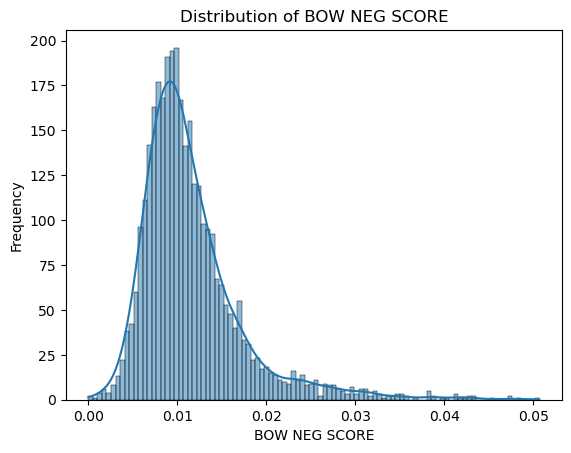

In [8]:
df_10ksp_filtered3.head(3)
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your DataFrame is named df_10ksp_filtered5 and it has a column named 'FINBERT SCORE'
sns.histplot(data=df_10ksp_filtered3, x='neg_proportion', bins=100, kde=True)
plt.title('Distribution of BOW NEG SCORE')
plt.xlabel('BOW NEG SCORE')
plt.ylabel('Frequency')
plt.show()

## 2. TF-IDF

In [10]:
df_10ksp_filtered4

,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,FISCAL YEAR END,Item 7 Content,Item 7A Content,...,Item 7A Word Count,Total Word Count,combined_text,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining
0,0000004904-00-000039,10-K405,19991231,20000324,Not found,AMERICAN ELECTRIC POWER COMPANY INC,0000004904,1231,Item 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,Item 7A. QUANTITATIVE AND QUALITATIVE DISCLOSU...,...,286,620,Item 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,0.077729,0.000000,0.006061,0.164904,0.000000,0.000000,0.089104
1,0000037996-00-000019,10-K,19991231,20000316,Not found,FORD MOTOR CO,0000037996,1231,Item 7. Management's Discussion and Analysis o...,Item 7A. Quantitative and Qualitative Disclosu...,...,871,5867,Item 7. Management's Discussion and Analysis o...,0.198667,0.111373,0.195466,0.036746,0.020203,0.015931,0.029081
2,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,0000052988,0930,Item 7. - Management's Discussion and Analysis...,Item 7A. QUALITATEE and QUANTITATEE DISCLOSURE...,...,11,2216,Item 7. - Management's Discussion and Analysis...,0.092394,0.048617,0.130855,0.287587,0.011903,0.017264,0.018340
3,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,0000060086,1231,"Item 7, Management's\nDiscussion and Analysis ...",Item 7A. Quantitative And Qualitative Disclosu...,...,1507,25260,"Item 7, Management's\nDiscussion and Analysis ...",0.884306,0.097071,0.159576,0.964639,0.011497,0.029582,0.039857
4,0000912057-00-014257,10-K405,19991231,20000329,Not found,NORTHERN STATES POWER CO /MN/,0000072903,1231,Item 7. \n\nNSP\nand Dairyland Power Cooperati...,Item 7A Quantitative and Qualitative Disclosur...,...,20,10178,Item 7. \n\nNSP\nand Dairyland Power Cooperati...,0.158061,0.055096,0.114201,0.143912,0.017351,0.029504,0.059729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0000950170-23-005559,10-K,20221231,20230301,20230301,Ceridian HCM Holding Inc.,0001725057,1231,Item 7. Management s Discussion and Analysis o...,Item 7A. Quantitative and Qualitat ive Disclos...,...,1036,11016,Item 7. Management s Discussion and Analysis o...,0.125223,0.092980,0.104656,0.076434,0.014253,0.020007,0.057815
3330,0000950170-23-064855,10-K,20230930,20231117,20231117,WestRock Co,0001732845,0930,Item 7. Management s Discussion and Analysis o...,Item 7A.\t QUANTITATIVE AND QUALITAT IVE DISCL...,...,2116,9889,Item 7. Management s Discussion and Analysis o...,0.214773,0.065670,0.227226,0.164213,0.020137,0.063520,0.142748
3331,0001739940-23-000008,10-K,20221231,20230223,20230223,Cigna Group,0001739940,1231,Item 7 of this Form 10-K for additional inform...,Item 7A. QUANTITATIVE AND QUALITATIVE DISCLOSU...,...,31,18765,Item 7 of this Form 10-K for additional inform...,0.501347,0.133076,0.217204,0.249253,0.022050,0.082285,0.113007
3332,0001748790-23-000030,10-K,20230630,20230817,20230817,Amcor plc,0001748790,0630,Item 7. - Management's Discussion and Analysis...,Item 7A. - Quantitative and Qualitative Disclo...,...,920,9112,Item 7. - Management's Discussion and Analysis...,0.357551,0.060308,0.198980,0.125443,0.013755,0.045255,0.128011
